# Diffusion-based Image Colorization

This notebook implements a compact, modular diffusion model to perform
grayscale -> color image colorization on CIFAR-10 (32x32). It's written to
run in Google Colab (CPU / T4 GPU) and includes optional experiment blocks
you can toggle (learnable timestep embeddings, attention on/off, DDIM sampler, color-histogram conditioning stub).

In [74]:
CFG = {
"dataset": "CIFAR10",
"img_size": 32,
"batch_size": 128, # reduce to 64 or 32 if running on CPU
"epochs": 30, # small number for quick iteration
"lr": 2e-4,
"device": "cuda" if __import__('torch').cuda.is_available() else "cpu",
"timesteps": 200, # number of diffusion steps (DDPM)
"sample_steps": 25, # steps used for sampling (DDIM/accelerated)
"channels": 3,
# Experiment toggles (for ablation study)
"use_learnable_t_emb": True,
"use_attention": False,
"use_ddim": True,
"max_train_batches": None # set to an int to limit batches per epoch for faster runs
}


print("Device:", CFG['device'])

Device: cuda


In [75]:
import math
import random
import time
from functools import partial


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

In [76]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)


def show_tensor_images(images, nrow=8, figsize=(8,8), title=None):
    images = images.clone().detach().cpu()
    grid = make_grid(images, nrow=nrow, normalize=True, value_range=(0,1))
    plt.figure(figsize=figsize)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

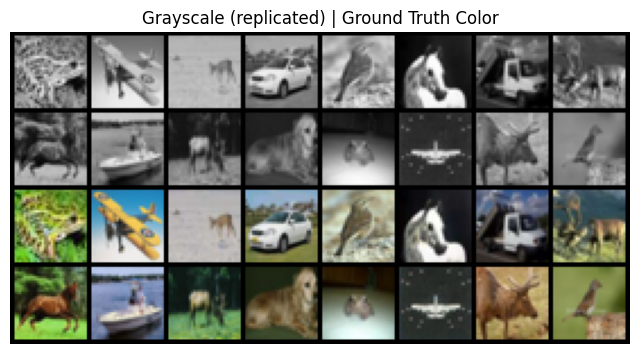

In [77]:
transform = transforms.Compose([
    transforms.ToTensor(), # [0,1]
])

train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
val_ds = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# helper: make 1-channel grayscale from 3-channel image
def rgb_to_gray(x):
    # x: Tensor [C,H,W] with C=3
    r, g, b = x[0], x[1], x[2]
    gray = 0.2989*r + 0.5870*g + 0.1140*b
    return gray.unsqueeze(0)


# Wrap dataset to return (grayscale, color)
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, base_ds):
        self.base = base_ds
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img, label = self.base[idx]
        # img in [0,1]
        gray = rgb_to_gray(img)
        return gray, img


train_ds_col = ColorizationDataset(train_ds)
val_ds_col = ColorizationDataset(val_ds)


train_loader = DataLoader(train_ds_col, batch_size=CFG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds_col, batch_size=CFG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)


# Peek
gr, col = next(iter(train_loader))
show_tensor_images(torch.cat([gr.repeat(1,3,1,1)[:16], col[:16]], dim=0), nrow=8, title='Grayscale (replicated) | Ground Truth Color')

In [78]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = CFG['timesteps']
betas = linear_beta_schedule(T).to(CFG['device'])
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# helpers that will be used in training/sampling
betas_t = betas
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# utility: extract a tensor of shape [batch_size, 1,1,1] for a timestep t

def extract(a, t, x_shape):
    # a: tensor [T], t: tensor of shape [B] with ints
    out = a.gather(-1, t).to(t.device) # Fix: Removed .cpu() from t (change if running cpu)
    return out.view(-1, *((1,)*(len(x_shape)-1)))

In [79]:
class SmallConvBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel=3, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=kernel, padding=padding),
            nn.GroupNorm(8, c_out),
            nn.SiLU(),
        )
    def forward(self, x):
        return self.block(x)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb


class LearnableTimestepEmbedding(nn.Module):
    def __init__(self, dim, max_steps=1000):
        super().__init__()
        self.emb = nn.Embedding(max_steps, dim)
    def forward(self, t):
        # t tensor of ints shape [B]
        return self.emb(t)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=4, base_ch=64, t_emb_dim=128, use_learnable_t_emb=False, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        self.t_emb_dim = t_emb_dim
        if use_learnable_t_emb:
            self.t_emb = LearnableTimestepEmbedding(t_emb_dim, max_steps=T)
        else:
            self.t_emb = SinusoidalPosEmb(t_emb_dim)
        # map timestep emb to channels
        self.time_mlp = nn.Sequential(nn.Linear(t_emb_dim, t_emb_dim*2), nn.SiLU(), nn.Linear(t_emb_dim*2, base_ch*2))


        # Downsampling path
        self.conv1 = SmallConvBlock(in_ch, base_ch) # Output: (B, base_ch, 32, 32)
        self.conv2 = SmallConvBlock(base_ch, base_ch*2) # Output: (B, base_ch*2, 16, 16) after pooling
        self.pool = nn.AvgPool2d(2)
        # Bottleneck
        self.conv3 = SmallConvBlock(base_ch*2, base_ch*2) # Output: (B, base_ch*2, 8, 8) after pooling
        # Upsampling path
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        # Changed conv4 to conv_up1 and adjusted its output channels
        self.conv_up1 = SmallConvBlock(base_ch*4, base_ch*2) # Output: (B, base_ch*2, 16, 16)
        # Added a new convolutional block for the final upsampling stage
        self.conv_up2 = SmallConvBlock(base_ch*3, base_ch) # Output: (B, base_ch, 32, 32)

        self.final = nn.Conv2d(base_ch, 3, kernel_size=1) # Predict noise for 3 color channels (Output: B, 3, 32, 32)


        if use_attention:
            # simple self-attention at bottleneck
            self.attn = nn.MultiheadAttention(embed_dim=base_ch*2, num_heads=4, batch_first=True)
        else:
            self.attn = None

    def forward(self, x, t, cond):
        # x: noisy color image [B,3,H,W]
        # cond: grayscale [B,1,H,W]
        # t: tensor of timesteps [B]
        B = x.shape[0]
        # concat conditioning
        h = torch.cat([x, cond], dim=1) # (B, 4, 32, 32)

        # Downsampling
        h1 = self.conv1(h) # (B, base_ch, 32, 32)
        h2 = self.conv2(self.pool(h1)) # (B, base_ch*2, 16, 16)

        # Bottleneck
        b = self.conv3(self.pool(h2)) # (B, base_ch*2, 8, 8)

        # Optional attention
        if self.attn is not None:
            # flatten spatial dims
            B, C, H, W = b.shape
            flat = b.view(B, C, H*W).permute(0,2,1) # [B, HW, C]
            attn_out, _ = self.attn(flat, flat, flat)
            attn_out = attn_out.permute(0,2,1).view(B, C, H, W)
            b = b + attn_out

        # Time embedding
        t_emb = self.t_emb(t)
        t_m = self.time_mlp(t_emb).view(B, -1, 1, 1)
        # Broadcast-add to bottleneck
        b = b + t_m

        # Upsampling path
        up1 = self.up(b) # (B, base_ch*2, 16, 16)
        cat1 = torch.cat([up1, h2], dim=1) # (B, base_ch*4, 16, 16)
        out1 = self.conv_up1(cat1) # (B, base_ch*2, 16, 16)

        up2 = self.up(out1) # (B, base_ch*2, 32, 32)
        cat2 = torch.cat([up2, h1], dim=1) # (B, base_ch*3, 32, 32)
        out2 = self.conv_up2(cat2) # (B, base_ch, 32, 32)

        # Final output
        out = self.final(out2) # (B, 3, 32, 32)
        return out

In [80]:
model = TinyUNet(in_ch=4, base_ch=64, t_emb_dim=128, use_learnable_t_emb=CFG['use_learnable_t_emb'], use_attention=CFG['use_attention']).to(CFG['device'])
print(model)


# count params
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print('Trainable params:', count_params(model))

TinyUNet(
  (t_emb): LearnableTimestepEmbedding(
    (emb): Embedding(200, 128)
  )
  (time_mlp): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (conv1): SmallConvBlock(
    (block): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
    )
  )
  (conv2): SmallConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (2): SiLU()
    )
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): SmallConvBlock(
    (block): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (2): SiLU()
    )
  )
  (up): Upsample(scale_factor=2.0, mode='nearest')
  (conv_

In [81]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_acp = extract(sqrt_alphas_cumprod, t, x_start.shape).to(x_start.device)
    sqrt_om_acp = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape).to(x_start.device)
    return sqrt_acp * x_start + sqrt_om_acp * noise


# loss: MSE between true noise and predicted noise
mse = nn.MSELoss()

In [82]:
optim = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=1e-6)


def train_one_epoch(epoch):
    model.train()
    pbar = tqdm(enumerate(train_loader), total=(len(train_loader) if CFG['max_train_batches'] is None else CFG['max_train_batches']))
    running_loss = 0.0
    for i, (gray, color) in pbar:
        if CFG['max_train_batches'] and i >= CFG['max_train_batches']:
            break
        gray = gray.to(CFG['device'])
        color = color.to(CFG['device'])
        batch_size = color.shape[0]
        t = torch.randint(0, T, (batch_size,), device=CFG['device']).long()
        noise = torch.randn_like(color)
        x_t = q_sample(color, t, noise=noise)
        # model predicts noise given x_t and cond
        pred_noise = model(x_t, t, gray)
        loss = mse(noise, pred_noise)
        optim.zero_grad()
        loss.backward()
        optim.step()
        running_loss += loss.item()
        if i % 50 == 0:
            pbar.set_description(f"Epoch {epoch} loss {running_loss/(i+1):.4f}")
    return running_loss / (i+1)

In [83]:
def p_sample(model, x_t, t, cond):
    # one reverse step (DDPM) predicting noise
    bet = betas_t[t].to(x_t.device)
    sqrt_alpha = torch.sqrt(alphas[t]).to(x_t.device)
    alpha_cum = alphas_cumprod[t].to(x_t.device)
    sqrt_one_minus_alpha_cum = torch.sqrt(1 - alpha_cum).to(x_t.device)
    # predicted noise
    pred_noise = model(x_t, t.repeat(x_t.shape[0]), cond)
    # estimate x0
    x0_pred = (x_t - sqrt_one_minus_alpha_cum.view(-1,1,1,1)*pred_noise) / torch.sqrt(alpha_cum).view(-1,1,1,1)
    # compute mean of p(x_{t-1} | x_t)
    coef1 = (bet * torch.sqrt(alphas_cumprod[:-1] if t>0 else torch.tensor([1.0])).to(x_t.device)) / (1. - alpha_cum)
    # simplified (vectorized) implementation below uses known formula for posterior mean
    posterior_mean_coef1 = bet / torch.sqrt(1. - alpha_cum)
    # for simplicity, use standard DDPM update with added noise
    # compute the posterior mean directly using common formula
    # NOTE: for stability we use vectorized math per batch using tensors extracted via extract()
    beta_t = extract(betas_t, t, x_t.shape).to(x_t.device)
    alpha_t = extract(alphas, t, x_t.shape).to(x_t.device)
    alpha_cum_t = extract(alphas_cumprod, t, x_t.shape).to(x_t.device)
    sqrt_recip_alpha_t = torch.sqrt(1.0/alpha_t)
    # predicted x0
    x0_pred = (x_t - torch.sqrt(1-alpha_cum_t)*pred_noise) / torch.sqrt(alpha_cum_t)
    # coef for mean
    mean = (torch.sqrt(alpha_cum_t)* (1 - alpha_t) / (1 - alpha_cum_t)) * x0_pred + (alpha_t * (1 - alpha_cum_t) / (1 - alpha_cum_t)) * x_t
    # add noise for non-zero timesteps
    if (t > 0):
        noise = torch.randn_like(x_t)
        sigma = torch.sqrt(beta_t)
        return mean + sigma * noise
    else:
        return mean

In [84]:
def ddim_sample(model, cond, shape, steps=50, eta=0.0):
    # cond: grayscale [B,1,H,W]
    device = cond.device
    B = shape[0]
    x = torch.randn(shape, device=device)
    # create time schedule
    seq = torch.linspace(T-1, 0, steps, dtype=torch.long)
    alphas_cum = alphas_cumprod.to(device)
    for i in range(steps):
        t = torch.full((B,), int(seq[i].item()), device=device, dtype=torch.long)
        with torch.no_grad():
            pred_noise = model(x, t, cond)
        alpha_t = extract(alphas_cum, t, x.shape).to(device)
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        x0_pred = (x - sqrt_one_minus_alpha_t * pred_noise) / sqrt_alpha_t
        # compute next x
        if i == steps-1:
            x = x0_pred
        else:
            t_next = torch.full((B,), int(seq[i+1].item()), device=device, dtype=torch.long)
            alpha_next = extract(alphas_cum, t_next, x.shape).to(device)
            sigma = eta * torch.sqrt((1 - alpha_next) / (1 - alpha_t) * (1 - alpha_t/alpha_next))
            dir_part = torch.sqrt(1.0 - alpha_next - sigma**2) * pred_noise
            noise = sigma * torch.randn_like(x)
            x = torch.sqrt(alpha_next) * x0_pred + dir_part + noise
    return x

Epoch 1 loss 0.1029: 100%|██████████| 391/391 [00:16<00:00, 23.44it/s]

Epoch 1 completed in 16.8s, loss 0.0970


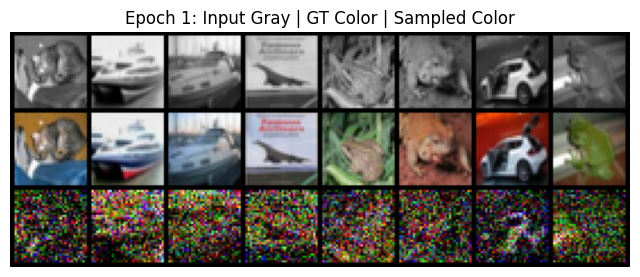

Epoch 2 loss 0.0344: 100%|██████████| 391/391 [00:21<00:00, 18.40it/s]

Epoch 2 completed in 21.3s, loss 0.0341


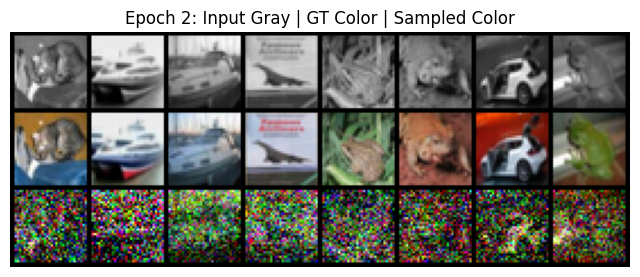

Epoch 3 loss 0.0296: 100%|██████████| 391/391 [00:18<00:00, 21.24it/s]

Epoch 3 completed in 18.5s, loss 0.0293


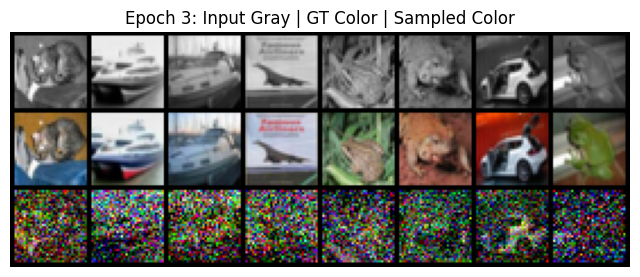

Epoch 4 loss 0.0254: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]

Epoch 4 completed in 18.1s, loss 0.0255


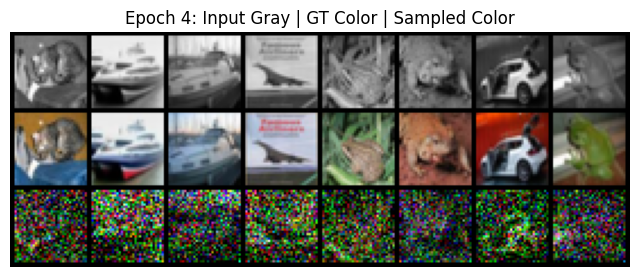

Epoch 5 loss 0.0246:   0%|          | 1/391 [00:00<00:51,  7.64it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7968983f0f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7968983f0f40>
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, i

Epoch 5 completed in 25.7s, loss 0.0237



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7968983f0f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7968983f0f40>^
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    ^self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^  ^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
   ^^ ^  ^^ ^^ ^ ^^ ^  ^^
  File "/u

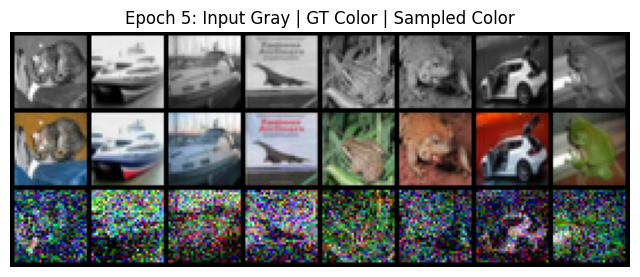

Epoch 6 loss 0.0221: 100%|██████████| 391/391 [00:25<00:00, 15.22it/s]

Epoch 6 completed in 25.8s, loss 0.0219


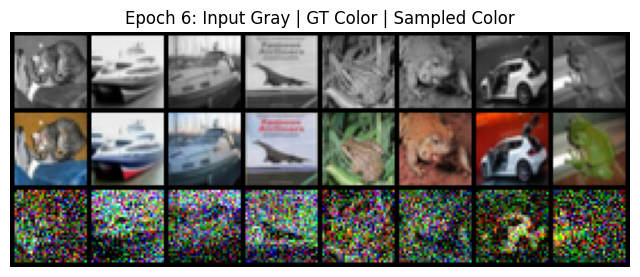

Epoch 7 loss 0.0211: 100%|██████████| 391/391 [00:23<00:00, 16.45it/s]

Epoch 7 completed in 23.9s, loss 0.0211


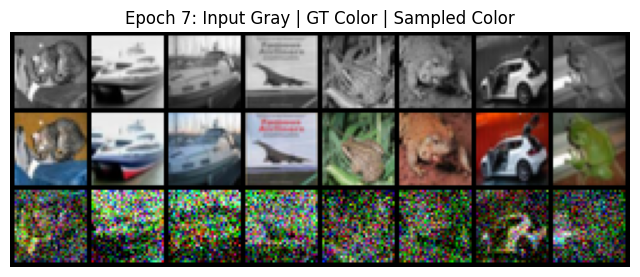

Epoch 8 loss 0.0194: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]

Epoch 8 completed in 18.9s, loss 0.0194


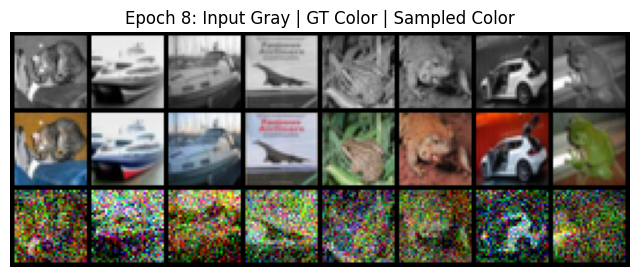

Epoch 9 loss 0.0195: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s]

Epoch 9 completed in 18.3s, loss 0.0193


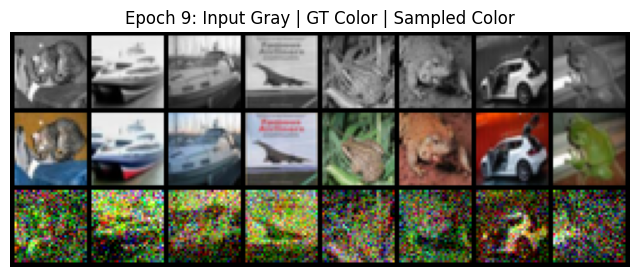

Epoch 10 loss 0.0188: 100%|██████████| 391/391 [00:18<00:00, 20.61it/s]


Epoch 10 completed in 19.1s, loss 0.0188


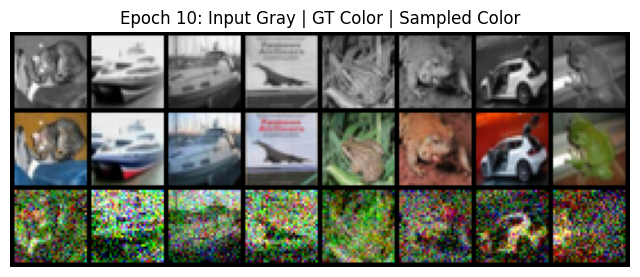

Epoch 11 loss 0.0178: 100%|██████████| 391/391 [00:20<00:00, 18.70it/s]

Epoch 11 completed in 21.0s, loss 0.0177


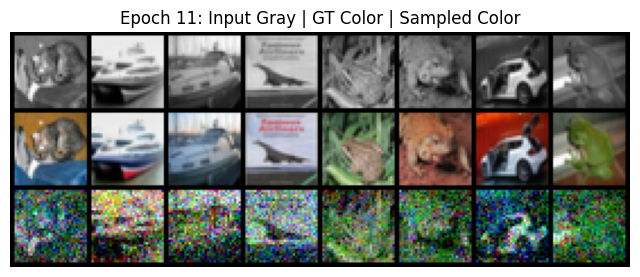

Epoch 12 loss 0.0183: 100%|██████████| 391/391 [00:19<00:00, 20.29it/s]

Epoch 12 completed in 19.4s, loss 0.0183


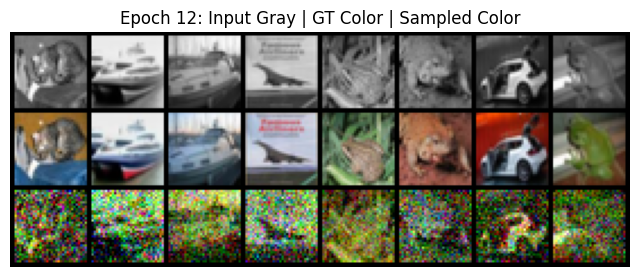

Epoch 13 loss 0.0170: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]

Epoch 13 completed in 18.9s, loss 0.0169


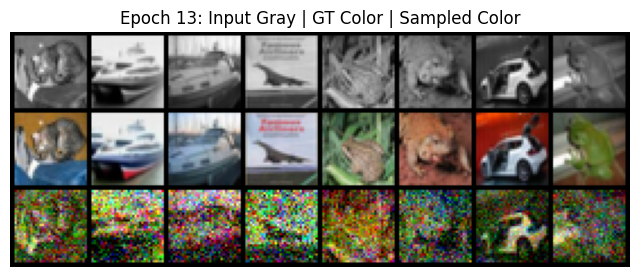

Epoch 14 loss 0.0171: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]

Epoch 14 completed in 18.8s, loss 0.0170


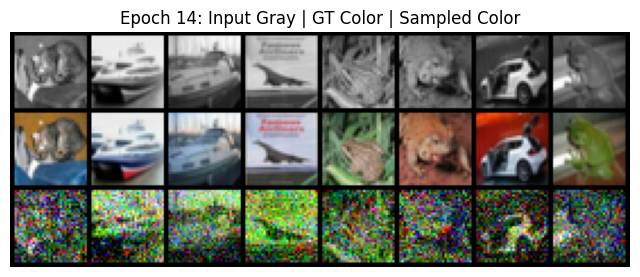

Epoch 15 loss 0.0168: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]

Epoch 15 completed in 21.7s, loss 0.0167


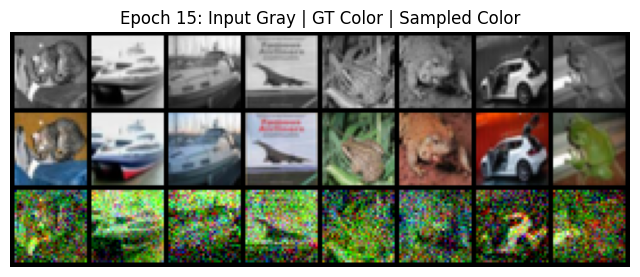

Epoch 16 loss 0.0164: 100%|██████████| 391/391 [00:19<00:00, 20.14it/s]

Epoch 16 completed in 19.5s, loss 0.0162


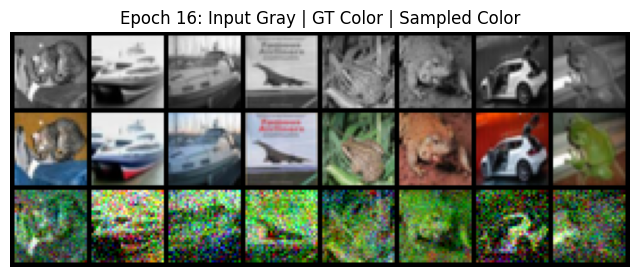

Epoch 17 loss 0.0161: 100%|██████████| 391/391 [00:21<00:00, 18.54it/s]

Epoch 17 completed in 21.2s, loss 0.0162


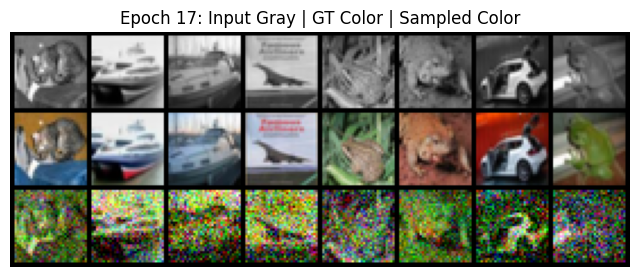

Epoch 18 loss 0.0160: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s]

Epoch 18 completed in 21.3s, loss 0.0159


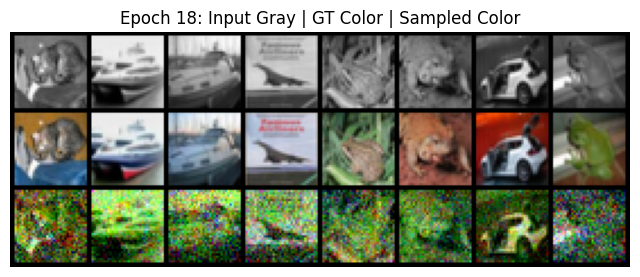

Epoch 19 loss 0.0158: 100%|██████████| 391/391 [00:21<00:00, 18.55it/s]

Epoch 19 completed in 21.2s, loss 0.0157


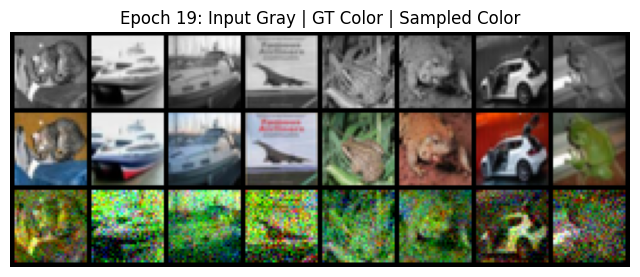

Epoch 20 loss 0.0154: 100%|██████████| 391/391 [00:23<00:00, 16.44it/s]

Epoch 20 completed in 23.9s, loss 0.0154


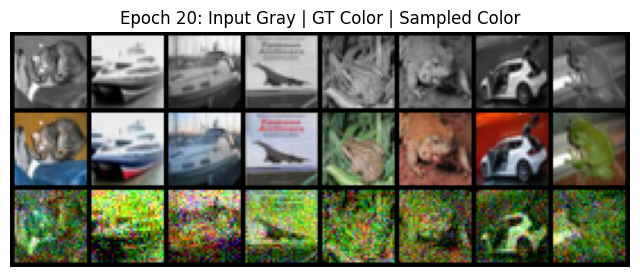

Epoch 21 loss 0.0152: 100%|██████████| 391/391 [00:22<00:00, 17.68it/s]

Epoch 21 completed in 22.2s, loss 0.0151


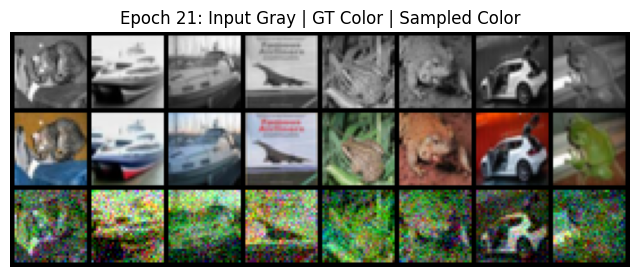

Epoch 22 loss 0.0153: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]

Epoch 22 completed in 23.1s, loss 0.0152


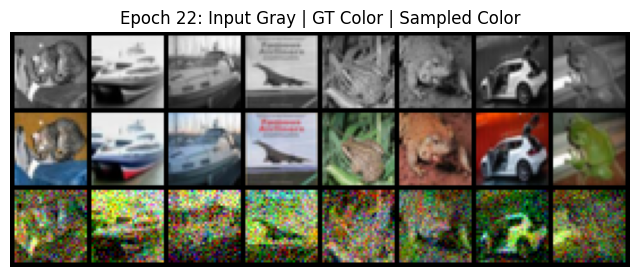

Epoch 23 loss 0.0148: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s]

Epoch 23 completed in 22.7s, loss 0.0148


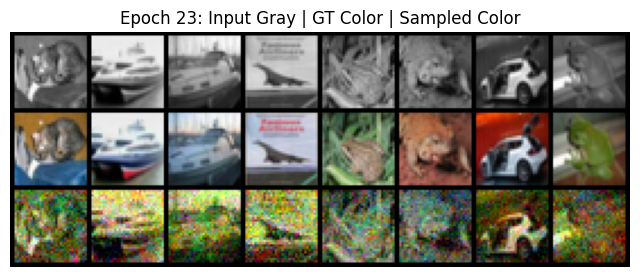

Epoch 24 loss 0.0146: 100%|██████████| 391/391 [00:22<00:00, 17.15it/s]

Epoch 24 completed in 22.9s, loss 0.0145


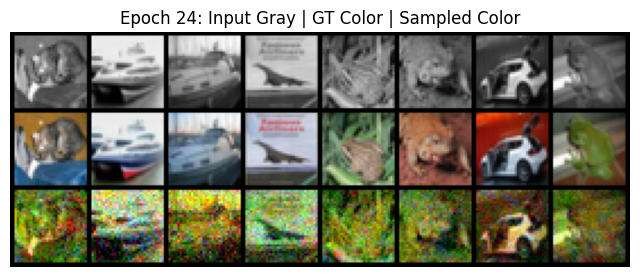

Epoch 25 loss 0.0148: 100%|██████████| 391/391 [00:22<00:00, 17.59it/s]

Epoch 25 completed in 22.3s, loss 0.0148


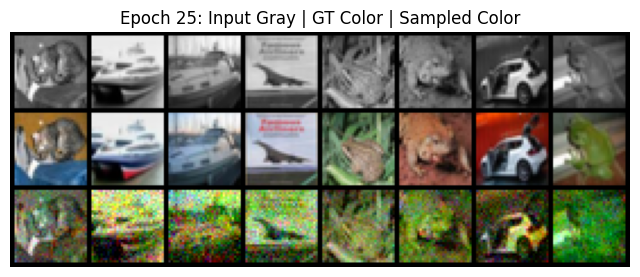

Epoch 26 loss 0.0144: 100%|██████████| 391/391 [00:23<00:00, 16.86it/s]

Epoch 26 completed in 23.3s, loss 0.0145


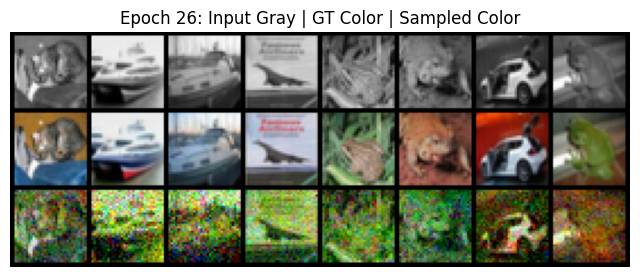

Epoch 27 loss 0.0142: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]

Epoch 27 completed in 22.8s, loss 0.0143


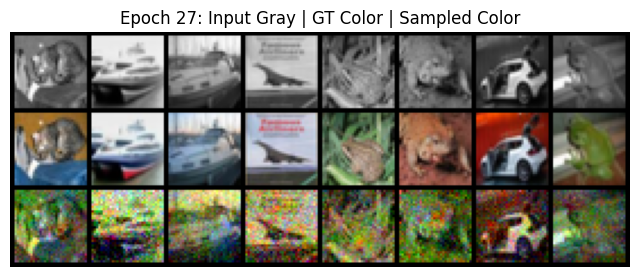

Epoch 28 loss 0.0140: 100%|██████████| 391/391 [00:23<00:00, 17.00it/s]

Epoch 28 completed in 23.1s, loss 0.0140


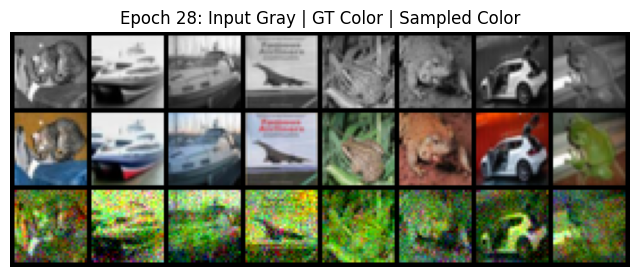

Epoch 29 loss 0.0135: 100%|██████████| 391/391 [00:22<00:00, 17.44it/s]

Epoch 29 completed in 22.5s, loss 0.0136


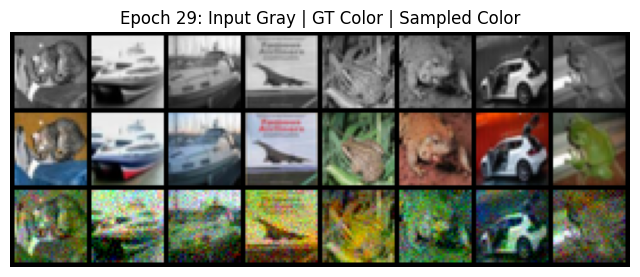

Epoch 30 loss 0.0143: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s]

Epoch 30 completed in 22.7s, loss 0.0142


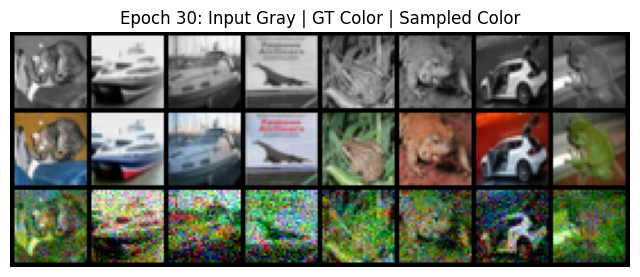

In [85]:
best_val = 1e9
for epoch in range(1, CFG['epochs']+1):
    t0 = time.time()
    loss = train_one_epoch(epoch)
    t1 = time.time()
    print(f"Epoch {epoch} completed in {t1-t0:.1f}s, loss {loss:.4f}")
    # quick validation visualization: take a batch from val set and sample
    model.eval()
    with torch.no_grad():
        gray, color = next(iter(val_loader))
        gray = gray.to(CFG['device'])
        color = color.to(CFG['device'])
        B = min(8, color.shape[0])
        cond = gray[:B]
        if CFG['use_ddim']:
            samples = ddim_sample(model, cond, shape=(B,3,CFG['img_size'],CFG['img_size']), steps=CFG['sample_steps'], eta=0.0)
        else:
            # naive full ancestral sampling (slow)
            x = torch.randn((B,3,CFG['img_size'],CFG['img_size']), device=CFG['device'])
            for t_ in reversed(range(T)):
                t = torch.full((B,), t_, device=CFG['device'], dtype=torch.long)
                x = p_sample(model, x, t, cond)
            samples = x
        # clamp to [0,1]
        samples = samples.clamp(0,1)
        # show grayscale, ground truth, and sample
        cat = torch.cat([cond.repeat(1,3,1,1)[:B], color[:B], samples[:B]], dim=0)
        show_tensor_images(cat, nrow=B, title=f'Epoch {epoch}: Input Gray | GT Color | Sampled Color')

In [86]:
torch.save({'model_state_dict': model.state_dict(), 'cfg': CFG}, 'colorization_diffusion_small.pth')
print('Saved model to colorization_diffusion_small.pth')

Saved model to colorization_diffusion_small.pth
